# Case_study_7_4

The goal of this case study is to implement the Ridge algorithm using the distributed ADMM. It is very similar to the LASSO problem but with a different second equation.

$$
{\bf{w}}_{i,k+1}=\underset{x_{i}}{\arg\min}\left(\frac{1}{n}\left\Vert {\bf{X}}_{i}{\bf{w}}_{i}-{\bf{y}}_{i}\right\Vert _{2}^{2}+\frac{\rho}{2}\left\Vert {\bf{w}}_{i}-{\bf{z}}_{k}+{\bf{u}}_{i,k}\right\Vert _{2}^{2}\right)
$$
$$
{\bf{z}}_{k+1}=\underset{z}{\arg\min}\left(\frac{\lambda}{2}\left\Vert {\bf{z}}\right\Vert _{2}^{2}+\frac{n\rho}{2}\left\Vert {\bf{z}}-\bar{{\bf{w}}}_{k+1}-\bar{{\bf{u}}}_{k}\right\Vert _{2}^{2}\right)
$$
$$
{\bf{u}}_{i,k+1}={\bf{u}}_{i,k}+{\bf{w}}_{i,k+1}-{\bf{z}}_{k+1}
$$

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
from local.lib.utils import solver_cvx,  eval_loss, plot_surface, grad_FOM, grad_SOM, BFGS, admm_ridge_dist
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

In [2]:
# Loading scenarios
# ===========================
scenario=2
data_reg, set_up =scenarios_regression(scenario)

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L2 = lambda w: cp.pnorm(w, p=2)**2

loss_LS_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)
grad_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@(X @ w - Y) + lambd * w
Hess_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@X + lambd * np.eye(X.shape[1])
grad_LS_L2_inst = lambda n, X, Y, w, lambd: (2*X.T@(X @ w - Y) + lambd * w)


# Different ways to solve theoreticaly the LS
# =========================================
# Solution of the empirical risk using CVX

w_L2_cvx=solver_cvx(set_up,loss_LS_L2);

Xtrain = set_up['Xtrain'][:,:set_up['d']+1]
w_opt=np.linalg.inv(2/set_up['Niter_train']*Xtrain.T@Xtrain + set_up['Lambda']*np.eye(set_up['d']+1))@((2/set_up['Niter_train'])*Xtrain.T)@set_up['ytrain'][:,0];

w = cp.Variable(w_L2_cvx.shape[0])
w.value = w_L2_cvx
loss_opt=loss_LS_L2(set_up['Niter_train'],set_up['Xtrain'][:,0:set_up['d']+1],set_up['ytrain'][:,0],w_L2_cvx,set_up['Lambda']).value
print(w_L2_cvx, w_opt)

          
# Gradient descent
out_gd = grad_FOM(set_up,grad_LS_L2)
loss_grad=eval_loss(out_gd,set_up,loss_LS_L2)

# Newton algorithm
out_hess =grad_SOM(set_up,grad_LS_L2,Hess_LS_L2)
loss_hess=eval_loss(out_hess,set_up,loss_LS_L2)
          
# BFGS algorithm
out_BFGS =BFGS(set_up,grad_LS_L2)
loss_BFGS=eval_loss(out_BFGS,set_up,loss_LS_L2)

# Distributed ADMM algorithm
out_admm_dist =admm_ridge_dist(set_up)
out_admm_dist2=np.c_[out_admm_dist[:,:int(set_up['Niter_train']/set_up['Number_nodes'])], np.kron(out_admm_dist[:,int(set_up['Niter_train']/set_up['Number_nodes'])].reshape(-1,1),np.ones((1,set_up['Niter_train']-int(set_up['Niter_train']/set_up['Number_nodes']))))]
loss_admm_dist=eval_loss(out_admm_dist2,set_up,loss_LS_L2)

[ 0.20049033  0.11299998  0.31850812  0.43460658 -0.1935255  -0.40004216
  0.69090825  0.09218441  0.16752282 -0.35714749 -0.04938209] [ 0.20044425  0.11297429  0.31849015  0.43457339 -0.19356807 -0.40006692
  0.69086312  0.09217921  0.16747579 -0.35719786 -0.04904775]


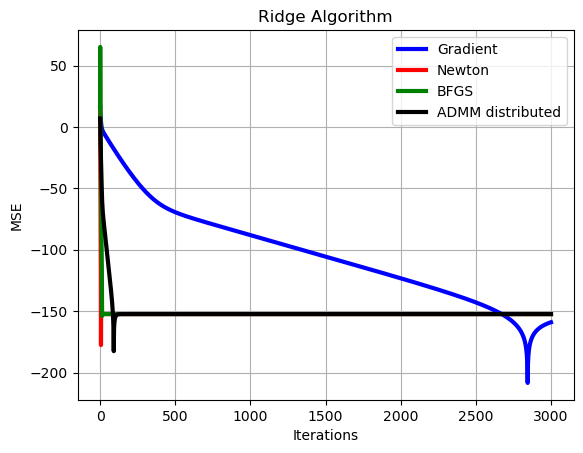

In [4]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_grad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_hess-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_BFGS-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='g', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_admm_dist-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='black', linewidth = 3)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(['Gradient','Newton','BFGS','ADMM distributed'])
plt.title('Ridge Algorithm')
plt.show()